In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_auc_score
import seaborn as sns



# Load and Preprocess Data 

In [32]:

# Load dataset
df = pd.read_csv('balanced_dataset_risky.csv')
df = df.dropna()

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label'].values  # expected to be 0 (benign), 1 (malware), 2 (risky)

# Feature Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get top k features
feature_importances = rf.feature_importances_
feature_names = X.columns
k = 6
top_features = [
    feature for feature, importance in sorted(
        zip(feature_names, feature_importances),
        key=lambda x: x[1],
        reverse=True
    )[:k]
]

# Final reduced feature set
X_selected = df[top_features]
X_selected = scaler.fit_transform(X_selected)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.4, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Print dataset info
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Selected top {k} features: {top_features}")

from sklearn.utils.class_weight import compute_class_weight

# ===== Class Weight Calculation =====
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
weights = torch.tensor(weights, dtype=torch.float32)
print(f"Class Weights: {weights}")

# ===== Loss Function with Class Weights =====
criterion = nn.CrossEntropyLoss(weight=weights)


X_train shape: torch.Size([420, 6])
y_train shape: torch.Size([420])
Selected top 6 features: ['total_methods', 'file_size_kb', 'num_files', 'num_providers', 'num_receivers', 'num_permissions']
Class Weights: tensor([0.7778, 0.7778, 2.3333])


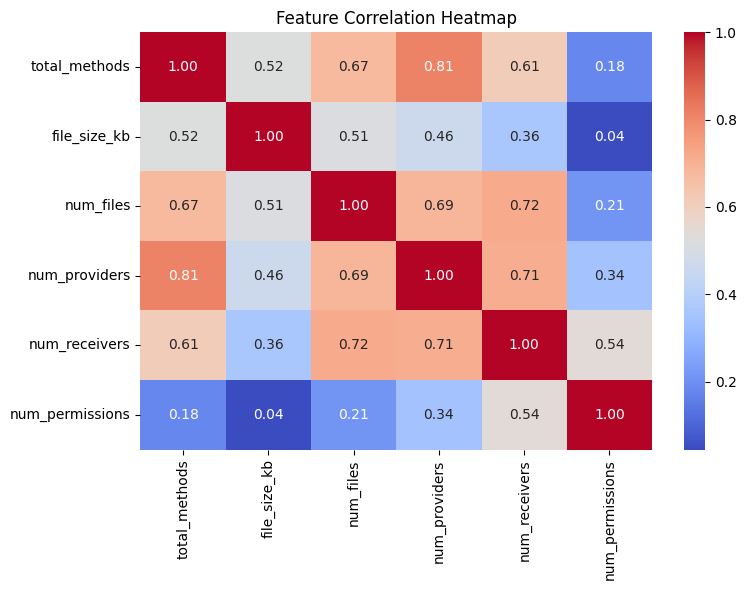

In [33]:
# Convert X_selected back to DataFrame with top feature names
X_selected_df = pd.DataFrame(X_selected, columns=top_features)

# Correlation Plot
plt.figure(figsize=(8, 6))
sns.heatmap(X_selected_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


# ANFIS Model

In [34]:
class ANFIS(nn.Module):
    def __init__(self, input_dim, num_rules, output_dim):
        super(ANFIS, self).__init__()
        self.num_rules = num_rules
        self.output_dim = output_dim

        # Gaussian membership parameters
        self.mu = nn.Parameter(torch.randn(input_dim, num_rules))  # centers
        self.sigma = nn.Parameter(torch.abs(torch.randn(input_dim, num_rules)) + 1e-6)  # spreads

        # Rule weights per output class (output_dim x num_rules)
        self.rule_weights = nn.Parameter(torch.randn(output_dim, num_rules))

    def forward(self, x):
        # Compute Gaussian membership values for each input and rule
        membership = torch.exp(-((x.unsqueeze(2) - self.mu) ** 2) / (2 * self.sigma ** 2 + 1e-6))
        # Aggregate membership across input features (AND operation → product)
        rule_activation = torch.prod(membership, dim=1)  # (batch_size, num_rules)
        
        # Normalize rule activations (fuzzy rule strengths)
        sum_activation = torch.sum(rule_activation, dim=1, keepdim=True) + 1e-6
        normalized_rule_activation = rule_activation / sum_activation

        # Compute class logits as weighted sum over rule strengths
        output = torch.matmul(normalized_rule_activation, self.rule_weights.T)  # (batch_size, output_dim)
        return output

# Initialize Model
input_dim = X_train.shape[1]
num_rules = 10
output_dim = 3
model = ANFIS(input_dim, num_rules, output_dim)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# training

Epoch [100/10000], Loss: 0.9493
Epoch [200/10000], Loss: 0.7907
Epoch [300/10000], Loss: 0.7329
Epoch [400/10000], Loss: 0.6975
Epoch [500/10000], Loss: 0.6687
Epoch [600/10000], Loss: 0.6287
Epoch [700/10000], Loss: 0.6086
Epoch [800/10000], Loss: 0.5697
Epoch [900/10000], Loss: 0.5213
Epoch [1000/10000], Loss: 0.4907
Epoch [1100/10000], Loss: 0.4751
Epoch [1200/10000], Loss: 0.4578
Epoch [1300/10000], Loss: 0.4242
Epoch [1400/10000], Loss: 0.4148
Epoch [1500/10000], Loss: 0.4073
Epoch [1600/10000], Loss: 0.4010
Epoch [1700/10000], Loss: 0.3961
Epoch [1800/10000], Loss: 0.3920
Epoch [1900/10000], Loss: 0.3885
Epoch [2000/10000], Loss: 0.3853
Epoch [2100/10000], Loss: 0.3826
Epoch [2200/10000], Loss: 0.3801
Epoch [2300/10000], Loss: 0.3778
Epoch [2400/10000], Loss: 0.3676
Epoch [2500/10000], Loss: 0.3651
Epoch [2600/10000], Loss: 0.3631
Epoch [2700/10000], Loss: 0.3614
Epoch [2800/10000], Loss: 0.3598
Epoch [2900/10000], Loss: 0.3585
Epoch [3000/10000], Loss: 0.3572
Epoch [3100/10000],

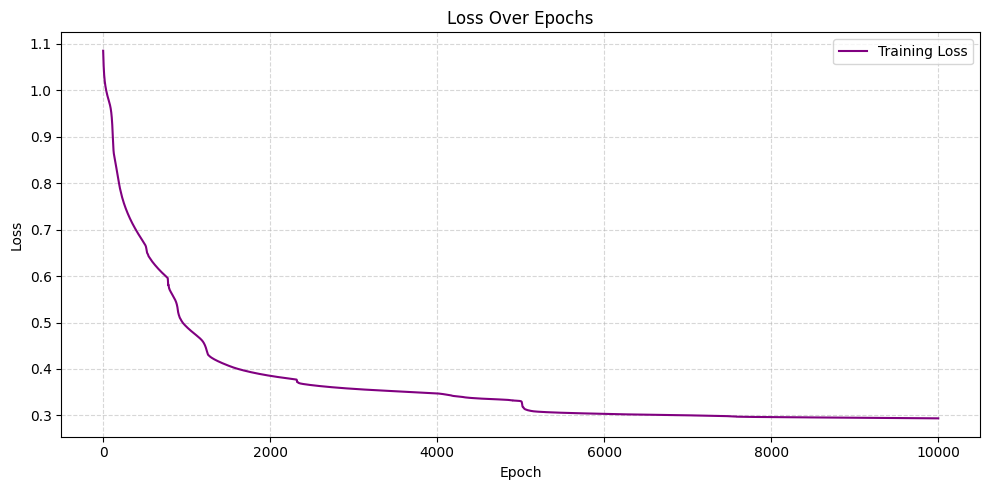

Test Loss: 0.3420


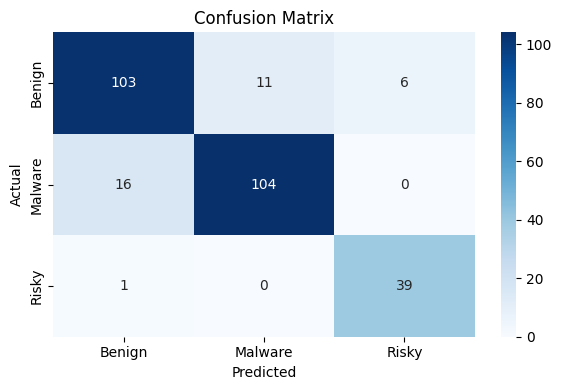

Confusion Matrix:
[[103  11   6]
 [ 16 104   0]
 [  1   0  39]]
Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.86      0.86       120
     Malware       0.90      0.87      0.89       120
       Risky       0.87      0.97      0.92        40

    accuracy                           0.88       280
   macro avg       0.88      0.90      0.89       280
weighted avg       0.88      0.88      0.88       280



In [35]:
# Training Loop
num_epochs = 10000
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())  # Track loss

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Loss over Epochs Plot
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation Block (Multi-class)
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert logits to predicted class indices
y_pred_class = torch.argmax(y_pred, dim=1).numpy()
y_test_numpy = y_test.numpy()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_numpy, y_pred_class)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malware', 'Risky'],
            yticklabels=['Benign', 'Malware', 'Risky'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_numpy, y_pred_class,
                            target_names=['Benign', 'Malware', 'Risky'],
                            zero_division=1))


Precision for Benign: 0.8372
Precision for Malware: 0.8651
Precision for Risky: 1.0000
Overall Precision (Macro-Average): 0.9008


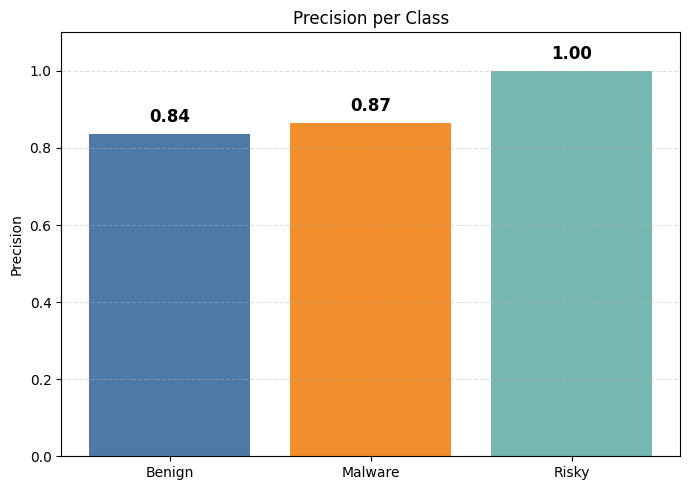

In [17]:
from sklearn.metrics import precision_score

# Calculate precision for each class
precision = precision_score(y_test_numpy, y_pred_class, average=None)

# Print precision for each class
class_labels = ['Benign', 'Malware', 'Risky']
for label, score in zip(class_labels, precision):
    print(f"Precision for {label}: {score:.4f}")

# Calculate and print overall precision (macro-average)
overall_precision = precision_score(y_test_numpy, y_pred_class, average='macro')
print(f"Overall Precision (Macro-Average): {overall_precision:.4f}")

import matplotlib.pyplot as plt
import numpy as np

# Visualize per-class precision as a bar plot
plt.figure(figsize=(7, 5))
x = np.arange(len(class_labels))
bars = plt.bar(x, precision, color=['#4e79a7', '#f28e2b', '#76b7b2'])

# Add value labels on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f"{precision[i]:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(x, class_labels)
plt.ylim(0, 1.1)
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Testing

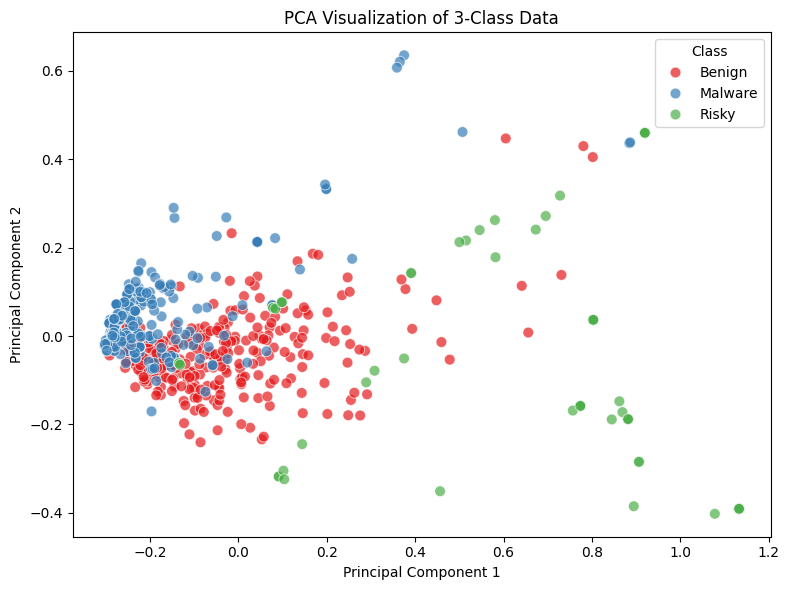

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: Convert y to class names for better legends (if currently numeric)
label_map = {
    0: 'Benign',
    1: 'Malware',
    2: 'Risky'
}
y_named = pd.Series(y).map(label_map)

# PCA to 2D
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_selected)  # X_selected is your scaled + selected feature matrix

# Create DataFrame for easier plotting
df_plot = pd.DataFrame({
    'PCA1': X_2D[:, 0],
    'PCA2': X_2D[:, 1],
    'Class': y_named
})

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='Class', palette='Set1', alpha=0.7, s=60)
plt.title('PCA Visualization of 3-Class Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')
plt.tight_layout()
plt.show()


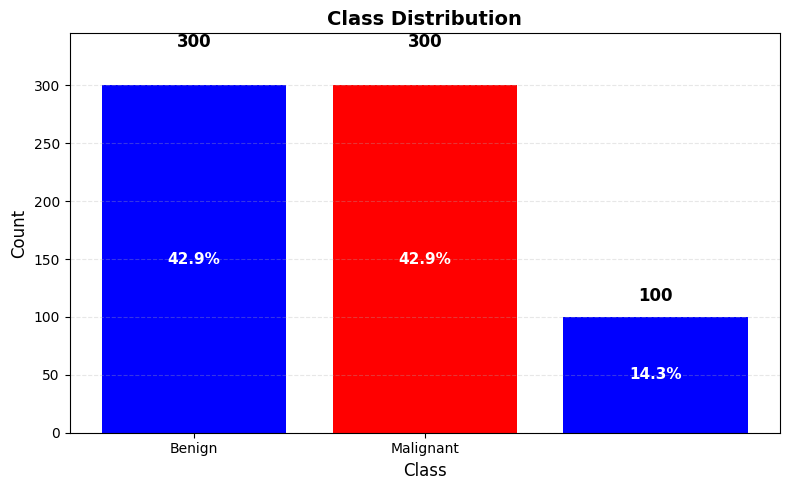


Class Distribution Summary:
Benign: 300 samples (42.9%)
Malignant: 300 samples (42.9%)
Total: 700 samples


In [20]:
plt.figure(figsize=(8, 5))
class_counts = pd.Series(y).value_counts()

# Create bar plot
bars = plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1*height,
             f'{int(height):,}',  # Format with comma for thousands
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Set labels and title
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)

# Ensure there's enough room for the labels
plt.ylim(0, max(class_counts.values) * 1.15)  # Add 15% padding at the top

# Add percentage labels inside bars
total = class_counts.sum()
for i, bar in enumerate(bars):
    percentage = (class_counts.values[i] / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{percentage:.1f}%', 
             ha='center', va='center', fontsize=11, 
             color='white', fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# Print summary statistics
print("\nClass Distribution Summary:")
print(f"Benign: {class_counts.get(0, 0):,} samples ({class_counts.get(0, 0)/total*100:.1f}%)")
print(f"Malignant: {class_counts.get(1, 0):,} samples ({class_counts.get(1, 0)/total*100:.1f}%)")
print(f"Total: {total:,} samples")

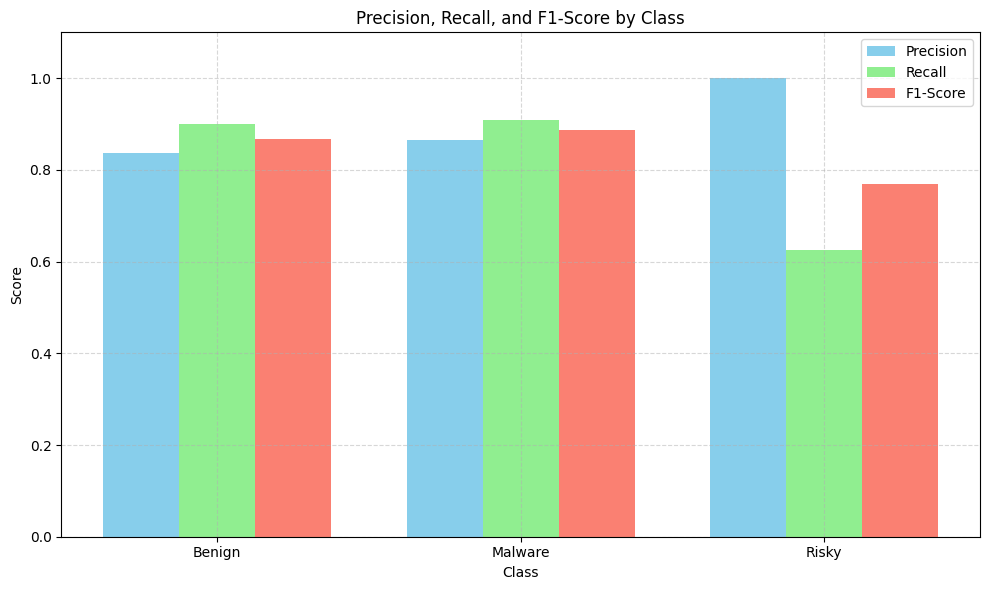

In [21]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Class labels (update if using string labels instead of ints)
class_labels = ['Benign', 'Malware', 'Risky']

# Calculate metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_numpy, y_pred_class, zero_division=1
)

# Bar plot
x = np.arange(len(class_labels))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, precision, width, label='Precision', color='skyblue')
ax.bar(x, recall, width, label='Recall', color='lightgreen')
ax.bar(x + width, f1, width, label='F1-Score', color='salmon')

# Labels and formatting
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.set_ylim(0, 1.1)
ax.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


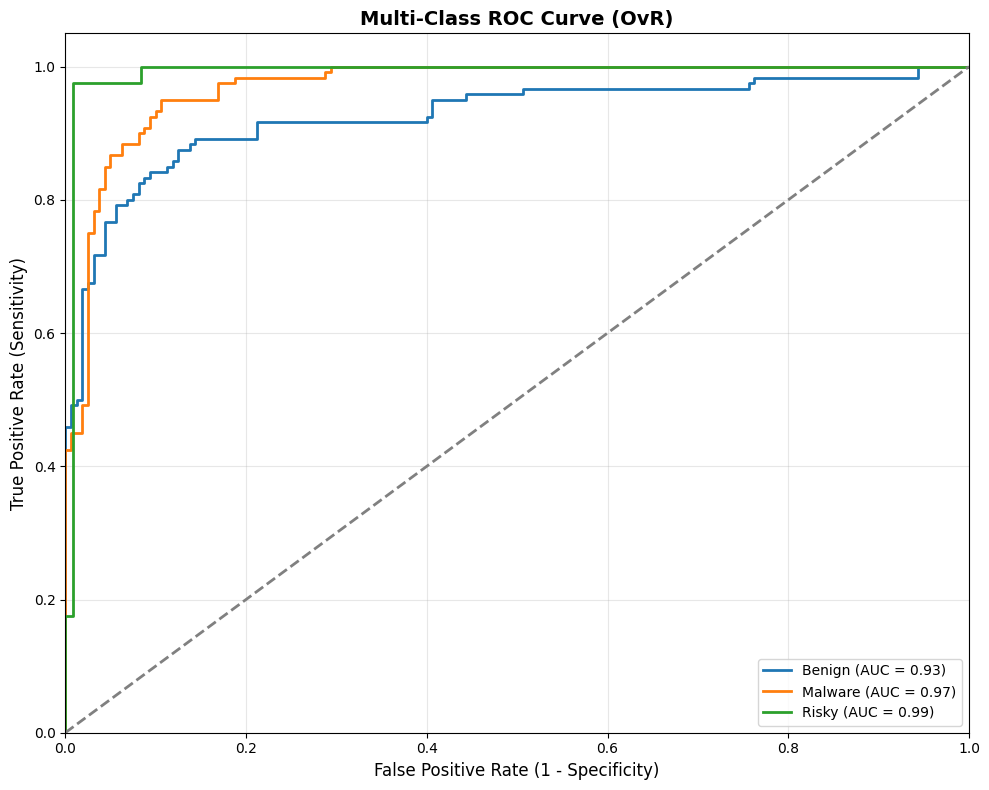

AUC for Benign: 0.9259
AUC for Malware: 0.9701
AUC for Risky: 0.9913


In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_multiclass_roc(model, X_test, y_test, class_names, figsize=(10, 8)):
    """
    Plots multi-class ROC curves using One-vs-Rest strategy.

    Args:
        model: Trained PyTorch model
        X_test: Tensor of test features
        y_test: Tensor of true class labels
        class_names: List of class names (e.g., ['Benign', 'Malware', 'Risky'])
        figsize: Tuple for figure size
    """
    n_classes = len(class_names)

    # Get prediction probabilities
    with torch.no_grad():
        y_score = model(X_test).numpy()  # shape: (num_samples, n_classes)

    y_test_np = y_test.numpy()
    y_test_bin = label_binarize(y_test_np, classes=np.arange(n_classes))  # shape: (num_samples, n_classes)

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=figsize)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose distinct colors

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Multi-Class ROC Curve (OvR)', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return roc_auc

# Usage:
class_names = ['Benign', 'Malware', 'Risky']
roc_auc_scores = plot_multiclass_roc(model, X_test, y_test, class_names)

# Print AUC per class
for cls, score in zip(class_names, roc_auc_scores.values()):
    print(f"AUC for {cls}: {score:.4f}")
